# Preprocessing Eval

Use this notebook to ensure that the preprocessing module performed as expected.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [2]:
import ops
from ops.imports_ipython import *
import pickle 
import glob
import tifffile
from microfilm import microplot
from microfilm.microplot import Micropanel

## SET PARAMETERS

In [13]:
# Directory for loading and saving files
METADATA_DIR = "output/metadata"
SBS_TIF_DIR = "output/sbs_tif"
PH_TIF_DIR = "output/ph_tif"
IC_DIR = "output/illumination_correction"
EVAL_DIR = "output/eval"

# Define wells to preprocess
WELLS = ["A1", "A2"]

# Define SBS cycles/tiles to preprocess
SBS_CYCLES = list(range(1, 12))
SBS_TILES = [1, 100]

# Define phenotype tiles to preprocess
PH_TILES = [1, 100]

# Parse function parameters
PARSE_FUNCTION_HOME = "input"
PARSE_FUNCTION_DATASET = "example_dataset"

# Test well and cycle to evaluate on
TEST_WELL = "A1"
TEST_CYCLE = "c1"

In [14]:
# Create eval directory
os.makedirs(EVAL_DIR, exist_ok=True)

# Determine number of wells and cycles
well_num = len(WELLS)
cycle_num = len(SBS_CYCLES)

# Get all SBS/PH TIFF files
sbs_tiff_files = glob.glob(f"{SBS_TIF_DIR}/*.tif")
ph_tiff_files = glob.glob(f"{PH_TIF_DIR}/*.tif")

### Check if metadata & file generation went to plan:

In [7]:
# Calculate the total number of expected metadata files
expected_metadata_files = well_num + (cycle_num * well_num)

# Calculate the total number of actual metadata files
metadata_files = [file for file in os.listdir(METADATA_DIR) if file.endswith('.pkl')]
num_metadata_files = len(metadata_files)

# Split metadata files into 20X (PH) and 10X (SBS) pickle files
metadata_files_ph = [file for file in metadata_files if '20X' in file]
metadata_files_sbs = [file for file in metadata_files if '10X' in file]

# Print the results
print("Expected number of metadata files:", expected_metadata_files)
print("Actual number of metadata files:", num_metadata_files)

# Initialize total row count for PH metadata
total_ph_metadata_rows = 0

# Iterate over each 20X (PH) metadata file
for ph_metadata_file in metadata_files_ph:
    # Construct the full file path
    file_path = f"{METADATA_DIR}/{ph_metadata_file}"
    
    # Open the PKL file in binary mode and load the data
    with open(file_path, 'rb') as file:
        ph_metadata = pickle.load(file)
        
        # Assuming ph_metadata is a pandas DataFrame, add its row count to the total
        total_ph_metadata_rows += len(ph_metadata)

# Print the total row count for PH metadata
print("Total number of metadata rows in all PH files:", total_ph_metadata_rows)

# Count the number of PH TIFF files
num_ph_tiff_files = len(ph_tiff_files)

# Define scaling factor (1 channel for PH images)
scaling_factor = 1  

# Calculate and print the expected number of metadata entries
expected_ph_metadata_entries = num_ph_tiff_files / scaling_factor
print(f"Expected number of metadata entries (PH TIFF files / scaling factor): {expected_ph_metadata_entries}")

# Initialize total row count for SBS metadata
total_sbs_metadata_rows = 0

# Iterate over each 10X (SBS) metadata file
for sbs_metadata_file in metadata_files_sbs:
    # Construct the full file path
    file_path = f"{METADATA_DIR}/{sbs_metadata_file}"
    
    # Open the PKL file in binary mode and load the data
    with open(file_path, 'rb') as file:
        sbs_metadata = pickle.load(file)
        
        # Assuming sbs_metadata is a pandas DataFrame, add its row count to the total
        total_sbs_metadata_rows += len(sbs_metadata)

# Print the total row count for SBS metadata
print("Total number of metadata rows in all SBS files:", total_sbs_metadata_rows)

# Count the number of SBS TIFF files
num_sbs_tiff_files = len(sbs_tiff_files)

# Calculate scaling factor for SBS 
# 1 channel for SBS images
scaling_factor = 1

# Calculate and print the expected number of metadata entries
expected_sbs_metadata_entries = num_sbs_tiff_files / scaling_factor
print(f"Expected number of metadata entries (SBS TIFF files / scaling factor): {expected_sbs_metadata_entries}")

Expected number of metadata files: 24
Actual number of metadata files: 24
Total number of metadata rows in all PH files: 4
Expected number of metadata entries (PH TIFF files / scaling factor): 4.0
Total number of metadata rows in all SBS files: 44
Expected number of metadata entries (SBS TIFF files / scaling factor): 44.0


### Generate maps of metadata, and check if initial sites is a logical choice

In [11]:
# Find and load PH metadata for the test well
ph_test_metadata = None
for ph_metadata_file in metadata_files_ph:
    if TEST_WELL in ph_metadata_file:
        with open(f"{METADATA_DIR}/{ph_metadata_file}", 'rb') as f:
            ph_test_metadata = pickle.load(f)
        break

if ph_test_metadata is not None:
    print(f"PH metadata file found for test well {TEST_WELL}!")
else:
    print(f"No PH metadata file found for test well {TEST_WELL}")

# Find and load SBS metadata for the test well and cycle
sbs_test_metadata = None
for sbs_metadata_file in metadata_files_sbs:
    if TEST_WELL in sbs_metadata_file and TEST_CYCLE in sbs_metadata_file:
        with open(f"{METADATA_DIR}/{sbs_metadata_file}", 'rb') as f:
            sbs_test_metadata = pickle.load(f)
        break

if sbs_test_metadata is not None:
    print(f"SBS metadata file found for test well {TEST_WELL} and cycle {TEST_CYCLE}!")
else:
    print(f"No SBS metadata file found for test well {TEST_WELL} and cycle {TEST_CYCLE}")

PH metadata file found for test well A1!
SBS metadata file found for test well A1 and cycle c1!


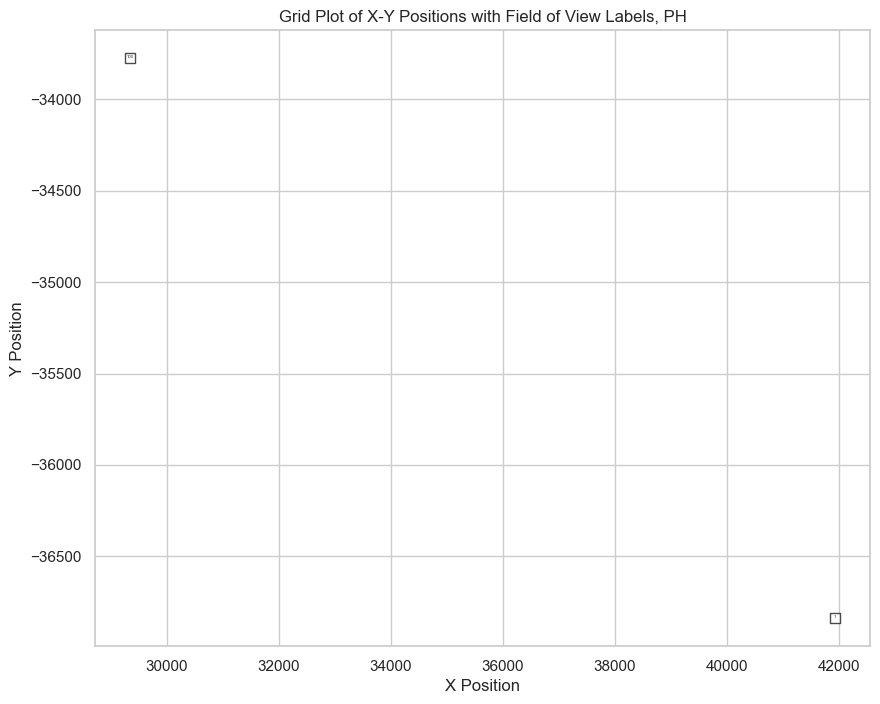

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot with squares for each point
plt.scatter(ph_test_metadata['x_data'], ph_test_metadata['y_data'], 
            s=50, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(ph_test_metadata['field_of_view']):
    plt.annotate(txt, (ph_test_metadata['x_data'].iloc[i], ph_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Grid Plot of X-Y Positions with Field of View Labels, PH')

# Save the figure as an SVG file
print("Grid view of phenotype metadata X-Y positions:")
plt.savefig(f"{EVAL_DIR}/ph_metadata_example.svg", format='svg', dpi=1200)
plt.show()

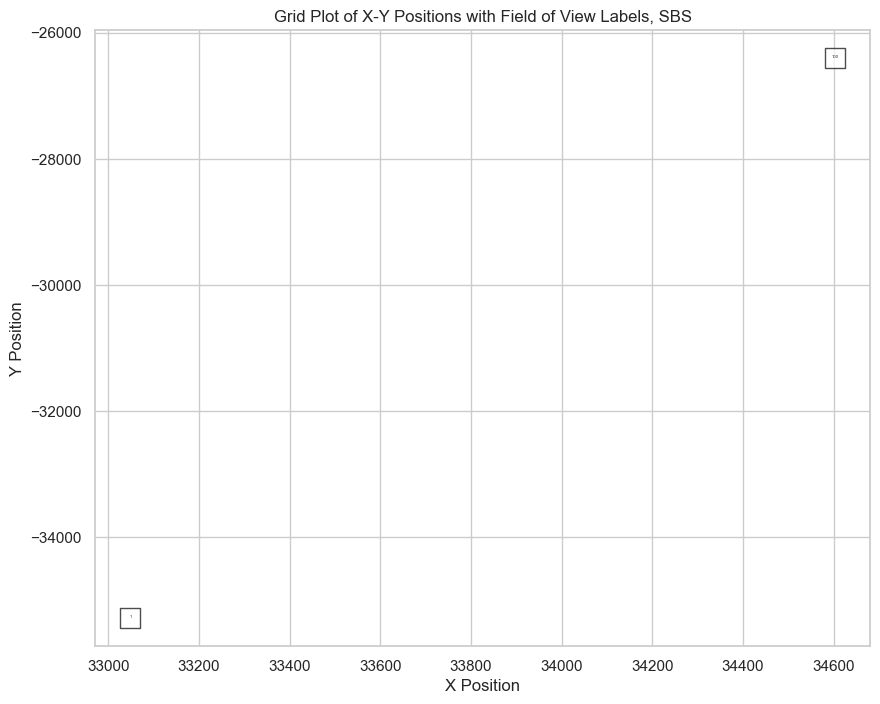

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot with squares for each point
plt.scatter(sbs_test_metadata['x_data'], sbs_test_metadata['y_data'], 
            s=200, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata['field_of_view']):
    plt.annotate(txt, (sbs_test_metadata['x_data'].iloc[i], sbs_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Grid Plot of X-Y Positions with Field of View Labels, SBS')

# Save the figure as an SVG file
print("Grid view of SBS metadata X-Y positions:")
plt.savefig(f"{EVAL_DIR}/sbs_metadata_example.svg", format='svg', dpi=1200)
plt.show()

Grid view of combined metadata X-Y positions:


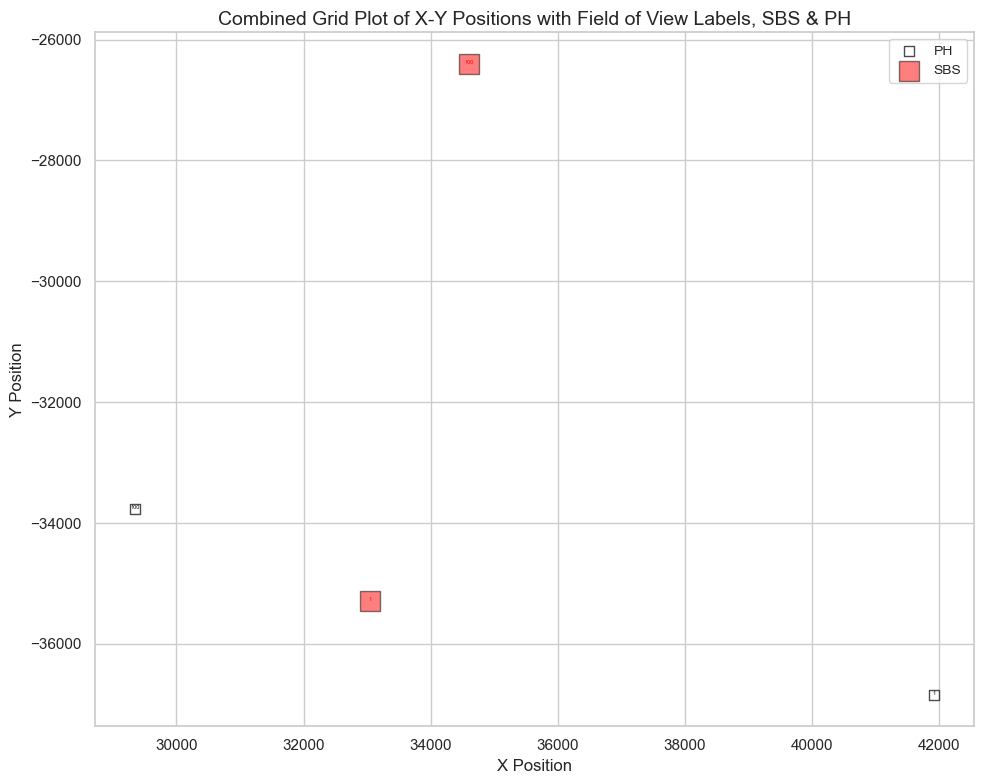

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Scatter plot for PH data
plt.scatter(ph_test_metadata['x_data'], ph_test_metadata['y_data'], 
            s=50, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7, label='PH')

# Label each PH point with the 'field_of_view' variable
for i, txt in enumerate(ph_test_metadata['field_of_view']):
    plt.annotate(txt, (ph_test_metadata['x_data'].iloc[i], ph_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=4, color='black')

# Scatter plot for SBS data
plt.scatter(sbs_test_metadata['x_data'], sbs_test_metadata['y_data'], 
            s=200, c='red', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.5, label='SBS')

# Label each SBS point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata['field_of_view']):
    plt.annotate(txt, (sbs_test_metadata['x_data'].iloc[i], sbs_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=4, color='red')

# Set labels and title
plt.xlabel('X Position', fontsize=12)
plt.ylabel('Y Position', fontsize=12)
plt.title('Combined Grid Plot of X-Y Positions with Field of View Labels, SBS & PH', fontsize=14)

plt.legend(fontsize=10)
plt.tight_layout()

# Save the figure as an SVG file
print("Grid view of combined metadata X-Y positions:")
plt.savefig(f"{EVAL_DIR}/combined_metadata_example.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()